In [1]:
import itertools
import random
import os

import numpy as np
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm import tqdm
import pathlib

from src.artificial_cluster_structure import ArtificialСlusterStructure
from src.correlation_block_model import CorrelationBlockModel
from src.params import PARAMS, PARAMS_NAME
from src.Stocks import Stocks
from src.StocksReader import ReaderStocksData

ModuleNotFoundError: No module named 'src'

In [27]:
def seed_all(seed: int = 123):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


# Download data

In [29]:
start_date = '2016-01-01'
end_date =   '2018-12-31'
path_to_data = './data/DataStocks/SP100'
path_to_save = './data/results/SP100_1618_true/'
name_common_file = 'SP100_60_stocks_all_results_test.csv'
name_specific_files = 'SP100_1618_60_stocks_true'
number_stocks = 60

ReaderData = ReaderStocksData(path_to_data)
DATA_OF_STOCKS, TICKERS = ReaderData.load_data(str(start_date), str(end_date))

ERROR:root:Error processing file data/DataStocks/SP100/.DS_Store: 'utf-8' codec can't decode byte 0x86 in position 27: invalid start byte


In [30]:
# true_tickers=['GILD',
#  'META',
#  'LIN',
#  'V',
#  'AMGN',
#  'TSLA',
#  'ORCL',
#  'AAPL',
#  'MA',
#  'GOOG',
#  'GS',
#  'NKE',
#  'DIS',
#  'UPS',
#  'CHTR',
#  'GD',
#  'CRM',
#  'AMT',
#  'MET',
#  'COF',
#  'SPG',
#  'LMT',
#  'USB',
#  'ACN',
#  'COP',
#  'AIG',
#  'QCOM',
#  'BK',
#  'CAT',
#  'PM',
#  'INTC',
#  'MRK',
#  'AXP',
#  'JPM',
#  'DUK',
#  'BA',
#  'CMCSA',
#  'BLK',
#  'AVGO',
#  'CVS',
#  'EMR',
#  'XOM',
#  'ABBV',
#  'GOOGL',
#  'TMUS',
#  'AMD',
#  'TXN',
#  'CSCO',
#  'NEE',
#  'PYPL',
#  'MO',
#  'GE',
#  'BMY',
#  'NFLX',
#  'DHR',
#  'SBUX',
#  'F',
#  'VZ',
#  'LOW',
#  'MS']

In [31]:
# res = []
# for stock in DATA_OF_STOCKS:
#     if stock.ticker in true_tickers:
#         res.append(stock)


In [32]:
# DATA_OF_STOCKS = res

# TICKERS = true_tickers

In [33]:
seed_all()
selected_indices = random.sample(range(99), number_stocks)

DATA_OF_STOCKS = [DATA_OF_STOCKS[i] for i in selected_indices]
TICKERS = [TICKERS[i] for i in selected_indices]

In [34]:
len(TICKERS)

60

In [ ]:
# len(DATA_OF_STOCKS[0].returns)

250

# Calculate the mean vector and covariance matrix

In [36]:
def get_covariance_matrix(Stocks: Stocks, tickers: np.array) -> pd.DataFrame:
    """
    Calculates the covariance matrix for the given list of stock objects.
    
    Args:
    - stocks (list): List of stock objects, each having a 'returns' attribute.
    - tickers (np.array): Array of stock tickers corresponding to the stocks.
    
    Returns:
    - pd.DataFrame: Covariance matrix.
    """
    covariance_matrix = []
    for stock_1 in Stocks:
        covv = []
        for stock_2 in Stocks:
            covv.append(np.cov(stock_1.returns, stock_2.returns)[0, 1])
        covariance_matrix.append(covv)

    return pd.DataFrame(covariance_matrix, columns = tickers, index = tickers)


def get_mean_vector(Stocks: Stocks) -> np.array:
    """
    Calculates the mean returns for the given list of stock objects.
    
    Args:
    - stocks (list): List of stock objects, each having a 'returns' attribute.
    
    Returns:
    - np.array: Array of mean returns.
    """
    mean_vector = []
    for stock in Stocks:
        mean_vector.append(stock.returns.mean())
    return np.array(mean_vector)

In [37]:
true_cov_matrix = get_covariance_matrix(DATA_OF_STOCKS, TICKERS)
true_mean_vec = get_mean_vector(DATA_OF_STOCKS)

In [38]:
# Создание всех возможных комбинаций параметров
keys, values = zip(*PARAMS.items())
combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]

keys_name, values_name = zip(*PARAMS_NAME.items())
combinations_name = [dict(zip(keys_name, combination)) for combination in itertools.product(*values_name)]
print(f'Total number of combinations: {len(combinations)}')

Total number of combinations: 216


In [40]:
combinations

[{'clustering_method': <bound method ClusteringMethods.single_clustering of <src.clustering_methods.ClusteringMethods object at 0x16ca8c150>>,
  'correlation_network': <bound method CorrelationMeasurement.Pearson of <src.correlation.CorrelationMeasurement object at 0x16ca8c290>>,
  'multivariate_distribution': <bound method MultivariateDistribution.normal_distribution of <src.multivariate_distribution.MultivariateDistribution object at 0x16ca8c310>>,
  'number_clusters': 2,
  'sample_size_of_observations': 40},
 {'clustering_method': <bound method ClusteringMethods.single_clustering of <src.clustering_methods.ClusteringMethods object at 0x16ca8c150>>,
  'correlation_network': <bound method CorrelationMeasurement.Pearson of <src.correlation.CorrelationMeasurement object at 0x16ca8c290>>,
  'multivariate_distribution': <bound method MultivariateDistribution.normal_distribution of <src.multivariate_distribution.MultivariateDistribution object at 0x16ca8c310>>,
  'number_clusters': 2,
  's

In [13]:
def one_experiment(
      cluster_method,
      correlation_method,
      multivariate_distribution,
      number_clusters,
      sample_size_of_observations,
      Stocks,
      true_cov_matrix,
      true_mean_vec,
) -> float:
   artificial_cluster_structure = ArtificialСlusterStructure()
   correlation_matrix = []
   for stock_1 in Stocks:
      row = []
      for stock_2 in Stocks:
         row.append(correlation_method(data_1 = stock_1.returns, data_2 = stock_2.returns))
      correlation_matrix.append(row)
   true_labels = cluster_method(np.array(correlation_matrix), number_clusters)

   gen_labels_ = artificial_cluster_structure.clustering(
      multivariate_distribution = multivariate_distribution,
      mean_vector = true_mean_vec,
      cov_matrix = true_cov_matrix,
      sample_size_of_observations = sample_size_of_observations,
      correlation_method = correlation_method,
      clustering_method = cluster_method,
      number_clusters = number_clusters
   )

   return adjusted_rand_score(true_labels, gen_labels_)
    

In [ ]:
results_experiments = pd.DataFrame()
number_repetitions = 100

for combination, combination_name in tqdm(zip(combinations, combinations_name), leave=False):
    print('=======', combination_name)
    
    ari_score_results = []
    for count in range(number_repetitions):
        result_score = one_experiment(
            cluster_method = combination['clustering_method'],
            correlation_method = combination['correlation_network'],
            multivariate_distribution = combination['multivariate_distribution'],
            number_clusters = combination['number_clusters'],
            sample_size_of_observations = combination['sample_size_of_observations'],
            Stocks = DATA_OF_STOCKS,
            true_cov_matrix = true_cov_matrix,
            true_mean_vec = true_mean_vec,
        )
        ari_score_results.append(result_score)
    combination_name['ARI'] = np.mean(ari_score_results)
    results_experiments = results_experiments._append(pd.Series(combination_name), ignore_index=True)
        

results_experiments

In [ ]:
results_experiments.to_csv(path_to_save + name_common_file)
# '/data/results/Brazil/stocks_20'
# /data/results/Brazil/stocks_20

# Сomparisons of clustering algorithms

In [ ]:

# from src.clustering_methods import ClusteringMethods
# from src.correlation import CorrelationMeasurement
# from src.multivariate_distribution import MultivariateDistribution

# cluster_method = ClusteringMethods()
# correlation_method = CorrelationMeasurement()
# multivariate_distribution = MultivariateDistribution()

# PARAMS = {
#     'clustering_method': [
#         cluster_method.single_clustering, 
#         cluster_method.louvain_clustering,
#         cluster_method.spectral_clustering,
#         cluster_method.normalized_spectral_clustering
#     ],
#     'correlation_network': [
#         correlation_method.Pearson, 
#         correlation_method.Kendall,
#         correlation_method.Fechner
#     ],
#     'number_clusters': [2, 4, 6],
# }

# PARAMS_NAME = {
#     'clustering_method': [
#         'single_clustering', 
#         'louvain_clustering',
#         'spectral_clustering',
#         'normalized_spectral_clustering'
#     ],
#     'correlation_network': [
#         'Pearson', 
#         'Kendall',
#         'Fechner'
#     ],
#     'number_clusters': [2, 4, 6],
# }

# # Создание всех возможных комбинаций параметров
# keys, values = zip(*PARAMS.items())
# combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]

# keys_name, values_name = zip(*PARAMS_NAME.items())
# combinations_name = [dict(zip(keys_name, combination)) for combination in itertools.product(*values_name)]
# print(f'Total number of combinations: {len(combinations)}')

# results_experiments = pd.DataFrame()


# for combination, combination_name in tqdm(zip(combinations, combinations_name), leave=False):
#     correlation_matrix = []
#     for stock_1 in DATA_OF_STOCKS:
#         row = []
#         for stock_2 in DATA_OF_STOCKS:
#             row.append(combination['correlation_network'](data_1 = stock_1.returns, data_2 = stock_2.returns))
#         correlation_matrix.append(row)
#     true_labels = combination['clustering_method'](np.array(correlation_matrix), combination['number_clusters'])
#     combination_name['labels'] = true_labels
#     results_experiments = results_experiments._append(pd.Series(combination_name), ignore_index=True)



Total number of combinations: 36


In [ ]:
# results_experiments

,clustering_method,correlation_network,number_clusters,labels
0,single_clustering,Pearson,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,single_clustering,Pearson,4,"[2, 2, 2, 2, 3, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, ..."
2,single_clustering,Pearson,6,"[4, 4, 2, 4, 3, 4, 0, 0, 0, 4, 4, 4, 0, 4, 0, ..."
3,single_clustering,Kendall,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,single_clustering,Kendall,4,"[2, 2, 2, 2, 3, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, ..."
5,single_clustering,Kendall,6,"[4, 4, 2, 4, 3, 4, 0, 0, 0, 4, 4, 4, 0, 4, 0, ..."
6,single_clustering,Fechner,2,"[1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, ..."
7,single_clustering,Fechner,4,"[1, 3, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, ..."
8,single_clustering,Fechner,6,"[1, 3, 4, 1, 5, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, ..."
9,louvain_clustering,Pearson,2,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
# correlations = ['Pearson', 'Kendall', 'Fechner']
# clusters_size = [2, 4, 6]

# for corr in correlations:
#     for size in clusters_size:
#         print(f'{corr} - {size}')
#         curr_results = results_experiments[(results_experiments['correlation_network'] == corr) & (results_experiments['number_clusters'] == size)]
#         results_similarity = []
#         clusterings = ['single_clustering', 'louvain_clustering', 'spectral_clustering', 'normalized_spectral_clustering']

#         for l in curr_results['labels']:
#             row = []
#             for l_1 in curr_results['labels']:
#                 row.append(adjusted_rand_score(l, l_1))
#             results_similarity.append(row)
#         df = pd.DataFrame(results_similarity, columns=clusterings, index=clusterings)
#         df.to_csv(f'{corr}_{size}.csv')
        


Pearson - 2
Pearson - 4
Pearson - 6
Kendall - 2
Kendall - 4
Kendall - 6
Fechner - 2
Fechner - 4
Fechner - 6


In [ ]:
# results_similarity = []
# clusterings = ['single_clustering', 'louvain_clustering', 'spectral_clustering', 'normalized_spectral_clustering']

# for l in curr_results['labels']:
#     row = []
#     for l_1 in curr_results['labels']:
#         row.append(adjusted_rand_score(l, l_1))
#     results_similarity.append(row)


In [ ]:
# pd.DataFrame(results_similarity, columns=clusterings, index=clusterings)

,single_clustering,louvain_clustering,spectral_clustering,normalized_spectral_clustering
single_clustering,1.000000,-0.054820,-0.043010,-0.077937
louvain_clustering,-0.054820,1.000000,0.777010,0.401454
spectral_clustering,-0.043010,0.777010,1.000000,0.279384
normalized_spectral_clustering,-0.077937,0.401454,0.279384,1.000000


# Saving data in the required form

In [4]:
import ast
def convert_table(data: pd.DataFrame, path: pathlib.Path, base_name_file: str) -> None:
    clustering_order = PARAMS_NAME['clustering_method']
    
    for multi_distribution in PARAMS_NAME['multivariate_distribution']:
        for corr_network in PARAMS_NAME['correlation_network']:
                for size_samples in PARAMS_NAME['sample_size_of_observations']:
                    
                    filtered_data = data[(data['correlation_network'] == corr_network) & 
                                        (data['multivariate_distribution'] == multi_distribution) & 
                                        (data['sample_size_of_observations'] == size_samples) &
                                        (data['clustering_method'] != 'louvain_clustering')]
                    
                    filtered_data['ARI'] = filtered_data['ARI'].round(2)
                    
                    filtered_data = filtered_data.drop(['cluster_distribution'], axis=1)

                    if filtered_data.empty:
                        continue

                    filtered_data = filtered_data[filtered_data['clustering_method'].isin(clustering_order)]
                    
                    filtered_data['clustering_method'] = pd.Categorical(
                        filtered_data['clustering_method'], 
                        categories=clustering_order, 
                        ordered=True
                    )

                    result = pd.pivot_table(
                        filtered_data, 
                        values = 'ARI', 
                        index = 'clustering_method', 
                        columns = 'number_clusters', 
                        aggfunc = 'first',
                        sort = False,
                        observed = False
                    )
                    
                    file_name = f'{base_name_file}_{multi_distribution}_{corr_network}_{size_samples}.csv'
                    result.to_csv(path + file_name)

                    filtered_data = data[(data['correlation_network'] == corr_network) & 
                                        (data['multivariate_distribution'] == multi_distribution) & 
                                        (data['sample_size_of_observations'] == size_samples) &
                                        (data['clustering_method'] == 'louvain_clustering')]
                    filtered_data['cluster_distribution'] = filtered_data['cluster_distribution'].map(ast.literal_eval)

                    def get_statistics(x):
                        return pd.DataFrame(x[1]).describe().T

                    info_stat = filtered_data['cluster_distribution'].map(get_statistics)

                    filtered_data = filtered_data.drop(['cluster_distribution'], axis=1)
                    result_louvain = pd.concat([filtered_data, info_stat.apply(lambda x: x.squeeze() if isinstance(x, pd.DataFrame) else x)], axis=1)
                    result_louvain = result_louvain.drop(['Unnamed: 0', 'count', 'correlation_network', 'multivariate_distribution', 'sample_size_of_observations'], axis=1)
                    result_louvain['ARI'] = result_louvain['ARI'].round(2)
                    result_louvain['mean'] = result_louvain['mean'].round(2)
                    result_louvain['std'] = result_louvain['std'].round(2)
                    file_name = f'{base_name_file}_{multi_distribution}_{corr_network}_{size_samples}_louvain.csv'
                    result_louvain.to_csv(path + file_name)




In [6]:
df = pd.read_csv("/Users/olgafrolova/Documents/ЛАТАС/code/data/SP100_60_stocks_all_results_1000_rep_18_01_25.csv")
convert_table(data = df, path = '/Users/olgafrolova/Documents/ЛАТАС/code/data/from_HSE_machine/SP100_60_1000_18_01_25/', base_name_file = 'SP100_60_1000')

/var/folders/dv/f5hnt9ln76s58c5pnq899n6h0000gn/T/ipykernel_40054/3155479026.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['ARI'] = filtered_data['ARI'].round(2)
/var/folders/dv/f5hnt9ln76s58c5pnq899n6h0000gn/T/ipykernel_40054/3155479026.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['cluster_distribution'] = filtered_data['cluster_distribution'].map(ast.literal_eval)
/var/folders/dv/f5hnt9ln76s58c5pnq899n6h0000gn/T/ipykernel_40054/3155479026.py:14: SettingWithCopyWar

# Correlation block model


In [ ]:
# def one_experiment_cbm(
#       cluster_method,
#       correlation_method,
#       multivariate_distribution,
#       number_clusters,
#       sample_size_of_observations,
#       true_cov_matrix,
#       true_mean_vec,
#       true_labels
# ) -> float:
   
#    artificial_cluster_structure = ArtificialСlusterStructure()
#    gen_labels_ = artificial_cluster_structure.clustering(
#       multivariate_distribution = multivariate_distribution,
#       mean_vector = true_mean_vec,
#       cov_matrix = true_cov_matrix,
#       sample_size_of_observations = sample_size_of_observations,
#       correlation_method = correlation_method,
#       clustering_method = cluster_method,
#       number_clusters = number_clusters
#    )

#    return adjusted_rand_score(true_labels, gen_labels_)
    

In [ ]:
# # Создание всех возможных комбинаций параметров
# keys, values = zip(*PARAMS.items())
# combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]

# keys_name, values_name = zip(*PARAMS_NAME.items())
# combinations_name = [dict(zip(keys_name, combination)) for combination in itertools.product(*values_name)]
# print(f'Total number of combinations: {len(combinations)}')
# print(f'Total number of name combinations: {len(combinations_name)}')

Total number of combinations: 216
Total number of name combinations: 216


In [ ]:
# results_experiments = pd.DataFrame()
# number_repetitions = 100
# number_vertices = 60

# for combination, combination_name in tqdm(zip(combinations, combinations_name), leave=False):
#     print('=======', combination_name)
    
#     cbm = CorrelationBlockModel(
#         num_clusters = combination['number_clusters'],
#         size_cluster = int(number_vertices / combination['number_clusters']),
#         r_in = 0.8,
#         r_out = 0.1
#     )
#     cbm = cbm.create_correlation_block_model()
#     ari_score_results = []

#     for count in range(number_repetitions):
#         result_score = one_experiment_cbm(
#             cluster_method = combination['clustering_method'],
#             correlation_method = combination['correlation_network'],
#             multivariate_distribution = combination['multivariate_distribution'],
#             number_clusters = combination['number_clusters'],
#             sample_size_of_observations = combination['sample_size_of_observations'],
#             true_cov_matrix = cbm['covariance_matrix'],
#             true_mean_vec = cbm['mean_vector'],
#             true_labels = cbm['labels']
#         )
#         ari_score_results.append(result_score)
#     combination_name['ARI'] = np.mean(ari_score_results)
#     results_experiments = results_experiments._append(pd.Series(combination_name), ignore_index=True)
        

0it [00:00, ?it/s]

======= {'clustering_method': 'normalized_spectral_clustering', 'correlation_network': 'Pearson', 'multivariate_distribution': 'normal_distribution', 'number_clusters': 2, 'sample_size_of_observations': 10, 'ARI': np.float64(0.5584574750874587)}


1it [01:49, 109.84s/it]

======= {'clustering_method': 'normalized_spectral_clustering', 'correlation_network': 'Pearson', 'multivariate_distribution': 'normal_distribution', 'number_clusters': 2, 'sample_size_of_observations': 20, 'ARI': np.float64(0.8583797615009413)}


KeyboardInterrupt: 

In [61]:
import ast
res = pd.DataFrame(columns=['correlation_network', 'multivariate_distribution', 'sample_size_of_observations','True label'])
for row in t.iterrows():
    
    input_string = row[1]['cluster_distribution']
    parsed_tuple = ast.literal_eval(input_string)
    number, array = parsed_tuple
    res.loc['correlation_network'] = row[1]['clustering_method']
    res.loc['multivariate_distribution'] = row[1]['multivariate_distribution']
    res.loc['sample_size_of_observations'] = row[1]['sample_size_of_observations']
    res.loc['True label'] = number



In [62]:
res

,correlation_network,multivariate_distribution,sample_size_of_observations,True label
correlation_network,normalized_spectral_clustering,normalized_spectral_clustering,normalized_spectral_clustering,normalized_spectral_clustering
multivariate_distribution,student_distribution,student_distribution,student_distribution,student_distribution
sample_size_of_observations,500,500,500,500
True label,6,6,6,6


In [47]:
import ast

# Given string to be parsed
input_string = "(2, [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])"

# Safely parse the string into a tuple using ast.literal_eval
parsed_tuple = ast.literal_eval(input_string)

# Separate the elements into a number and a list
number, array = parsed_tuple
type(number), type(array)


(int, list)

In [ ]:
import ast

input_string = "(2, [2, 2, 2, 2, 2, 2, 2, 2, 2, 2])"
result = ast.literal_eval(input_string)
t = pd.DataFrame(result[1]).describe().T


In [ ]:
import pandas as pd

t = pd.DataFrame(result[1]).describe().T


In [18]:
t['num clusters'] = [3]

In [19]:
t

,count,mean,std,min,25%,50%,75%,max,num clusters
0,10.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,3


# Visualization

In [124]:
import re
import os
from typing import List, Union
import matplotlib.pyplot as plt

def extract_number(filename: pathlib.Path)-> Union[int, float]:
    match = re.search(r"_(\d+)\.csv", filename)
    return int(match.group(1)) if match else float('inf')

def get_files(folder_path: pathlib.Path) -> List[str]:
    files = []
    for file_name in os.listdir(folder_path):
        # print("file", file_name)
        if os.path.isfile(os.path.join(folder_path, file_name)):
            # print()
            # if 'new2_smallstep' in os.path.join(folder_path, file_name):
            files.append(os.path.join(folder_path, file_name))
    # print(files)
    sorted_files = sorted(files)
    print(sorted_files)
    return sorted_files

def extractor_scores(files: List[str]) -> dict:
    routs = {
         'single_clustering': [],
         'louvain_clustering': [],
         'spectral_clustering': [],
         'normalized_spectral_clustering': []
        }
    for file in files:        
        df = pd.read_csv(file)
        for clustering_method in PARAMS_NAME['clustering_method']:
                df_rout= df[(df['clustering_method'] == clustering_method) &
                            (df['correlation_network'] == 'Fechner') &
                            (df['multivariate_distribution'] == 'student_distribution') &
                            (df['sample_size_of_observations'] == 500) &
                            (df['number_clusters'] == 6)]
                routs[clustering_method].append(float(df_rout['ARI']))
    return routs

def visual_iteration_r_out(data: dict) -> None:
    plt.figure(figsize=(8, 5))
    for clustering_method, scores in data.items():
        plt.plot(np.arange(0, 0.85, 0.05), scores,linestyle='-', label=clustering_method)

    plt.title('Dependence of metric on r_out', fontsize=14)
    plt.xlabel('r_out', fontsize=12)
    plt.ylabel('Metric value', fontsize=12)
    # plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')  # Линия уровня 0
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

def draw_graph(folder_path: pathlib.Path):
    files = get_files(folder_path)
    scores = extractor_scores(files)
    visual_iteration_r_out(scores)    

['data/cbm_100_18_01_25/Acorrelation_block_model_all_results_18_01_25_rin_0.8_rout0.0.csv', 'data/cbm_100_18_01_25/Bcorrelation_block_model_all_results_18_01_25_rin_0.8_rout0.05.csv', 'data/cbm_100_18_01_25/Ccorrelation_block_model_all_results_18_01_25_rin_0.8_rout0.1.csv', 'data/cbm_100_18_01_25/Dcorrelation_block_model_all_results_18_01_25_rin_0.8_rout0.15.csv', 'data/cbm_100_18_01_25/Ecorrelation_block_model_all_results_18_01_25_rin_0.8_rout0.2.csv', 'data/cbm_100_18_01_25/Fcorrelation_block_model_all_results_18_01_25_rin_0.8_rout0.25.csv', 'data/cbm_100_18_01_25/Gcorrelation_block_model_all_results_18_01_25_rin_0.8_rout0.3.csv', 'data/cbm_100_18_01_25/Hcorrelation_block_model_all_results_18_01_25_rin_0.8_rout0.35.csv', 'data/cbm_100_18_01_25/Icorrelation_block_model_all_results_18_01_25_rin_0.8_rout0.4.csv', 'data/cbm_100_18_01_25/Jcorrelation_block_model_all_results_18_01_25_rin_0.8_rout0.45.csv', 'data/cbm_100_18_01_25/Kcorrelation_block_model_all_results_18_01_25_rin_0.8_rout0.5

/var/folders/dv/f5hnt9ln76s58c5pnq899n6h0000gn/T/ipykernel_40054/1730783618.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  routs[clustering_method].append(float(df_rout['ARI']))
/var/folders/dv/f5hnt9ln76s58c5pnq899n6h0000gn/T/ipykernel_40054/1730783618.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  routs[clustering_method].append(float(df_rout['ARI']))
/var/folders/dv/f5hnt9ln76s58c5pnq899n6h0000gn/T/ipykernel_40054/1730783618.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  routs[clustering_method].append(float(df_rout['ARI']))
/var/folders/dv/f5hnt9ln76s58c5pnq899n6h0000gn/T/ipykernel_40054/1730783618.py:38: FutureWarning: Calling float on a single element Series is deprecate

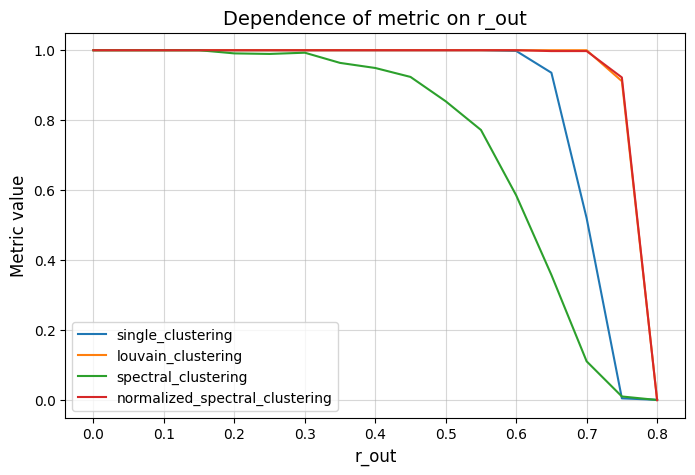

In [125]:
draw_graph("data/cbm_100_18_01_25")

In [17]:
file_paths = [
    '/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/0correlation_block_model_all_results_16_01_24_rin_0.8_rout0.0.csv',
    '/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/10correlation_block_model_all_results_16_01_24_rin_0.8_rout0.5.csv',
    '/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/11correlation_block_model_all_results_16_01_24_rin_0.8_rout0.55.csv',
    '/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/12correlation_block_model_all_results_16_01_24_rin_0.8_rout0.6.csv',
    '/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/13correlation_block_model_all_results_16_01_24_rin_0.8_rout0.65.csv',
    '/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/14correlation_block_model_all_results_16_01_24_rin_0.8_rout0.7.csv',
    '/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/15correlation_block_model_all_results_16_01_24_rin_0.8_rout0.75.csv',
    '/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/16correlation_block_model_all_results_16_01_24_rin_0.8_rout0.8.csv',
    '/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/1correlation_block_model_all_results_16_01_24_rin_0.8_rout0.05.csv',
    '/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/2correlation_block_model_all_results_16_01_24_rin_0.8_rout0.1.csv',
    '/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/3correlation_block_model_all_results_16_01_24_rin_0.8_rout0.15.csv',
    '/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/4correlation_block_model_all_results_16_01_24_rin_0.8_rout0.2.csv',
    '/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/5correlation_block_model_all_results_16_01_24_rin_0.8_rout0.25.csv',
    '/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/6correlation_block_model_all_results_16_01_24_rin_0.8_rout0.3.csv',
    '/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/7correlation_block_model_all_results_16_01_24_rin_0.8_rout0.35.csv',
    '/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/8correlation_block_model_all_results_16_01_24_rin_0.8_rout0.4.csv',
    '/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/9correlation_block_model_all_results_16_01_24_rin_0.8_rout0.45.csv'
]

# Refined regex to match "rout" followed by a valid float
def extract_rout(file_path):
    import re
    match = re.search(r'rout([0-9]+\\.[0-9]+)$', file_path)
    return float(match.group(1)) if match else float('inf')

# Sort the files by the extracted rout value
sorted_files = sorted(file_paths, key=extract_rout)

# Print the sorted file paths
for file in sorted_files:
    print(file)


/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/0correlation_block_model_all_results_16_01_24_rin_0.8_rout0.0.csv
/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/10correlation_block_model_all_results_16_01_24_rin_0.8_rout0.5.csv
/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/11correlation_block_model_all_results_16_01_24_rin_0.8_rout0.55.csv
/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/12correlation_block_model_all_results_16_01_24_rin_0.8_rout0.6.csv
/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/13correlation_block_model_all_results_16_01_24_rin_0.8_rout0.65.csv
/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/14correlation_block_model_all_results_16_01_24_rin_0.8_rout0.7.csv
/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/15correlation_block_model_all_results_16_01_24_rin_0.8_rout0.75.csv
/Users/olgafrolova/Documents/ЛАТАС/code/data/graphs/16correlation_block_model_all_results_16_01_24_rin_0.8_rout0.8.csv
/Users/olgafrolova/Documents/ЛАТАС/code/data/g

# Разные степени свободы у Стьюдента

In [139]:
import re
import os
from typing import List, Union
import matplotlib.pyplot as plt
import pandas as pd
import pathlib

def extract_number(filename: pathlib.Path) -> Union[int, float]:
    match = re.search(r"_(\d+)\.csv", filename)
    return int(match.group(1)) if match else float('inf')

def get_files(folder_path: pathlib.Path) -> List[str]:
    files = []
    for file_name in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file_name)):
            files.append(os.path.join(folder_path, file_name))
    sorted_files = sorted(files)
    print(sorted_files)
    return sorted_files

def extractor_scores(files: List[str]) -> dict:
    routs = {
         'single_clustering': [],
         'louvain_clustering': [],
         'spectral_clustering': [],
         'normalized_spectral_clustering': []
        }
    for file in files:        
        df = pd.read_csv(file)
        for clustering_method in ['single_clustering', 'louvain_clustering', 'spectral_clustering', 'normalized_spectral_clustering']:
            df_rout = df[(df['clustering_method'] == clustering_method) &
                         (df['correlation_network'] == 'Fechner') &
                         (df['multivariate_distribution'] == 'student_distribution') &
                         (df['sample_size_of_observations'] == 500) &
                         (df['number_clusters'] == 6)]
            routs[clustering_method].append(float(df_rout['ARI']))
    print(routs)
    return routs

def visual_iteration_r_out_barchart(data: dict) -> None:
    categories = list(data.keys())
    values = list(data.values())

    x = range(len(categories))  # Categories on x-axis
    bar_width = 0.25

    # Define positions for each group
    num_files = len(values[0])  # Number of files
    positions = [i - bar_width * (num_files - 1) / 2 for i in x]

    colors = ['#4e79a7', '#f28e2c', '#76b7b2']
    labels = ['n = 2', 'n = 2.5', 'n = 3']

    plt.figure(figsize=(12, 7))

    for idx in range(num_files):
        bars = plt.bar([p + idx * bar_width for p in positions],
                       [v[idx] for v in values],
                       bar_width,
                       label=labels[idx],
                       color=colors[idx % len(colors)],
                       edgecolor='black')
        # Add text on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=10, color='black')

    # Customize plot appearance
    plt.xticks(x, categories, rotation=20, ha="right", fontsize=12)
    plt.xlabel("Clustering Method", fontsize=14, labelpad=10)
    plt.ylabel("ARI Metric Value", fontsize=14, labelpad=10)
    plt.title("Comparison of Clustering Methods by ARI Values", fontsize=16, pad=20, weight='bold')
    plt.legend(title="Degree of Freedom (n)", fontsize=12, title_fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def draw_graph(folder_path: pathlib.Path):
    files = get_files(folder_path)
    scores = extractor_scores(files)
    visual_iteration_r_out_barchart(scores)


['data/diff_student_market/SP100_60_stocks_all_results_1000_rep_18_01_25.csv', 'data/diff_student_market/SP100_60_stocks_all_results_1000_rep_19_01_25.csv', 'data/diff_student_market/SP100_60_stocks_all_results_1000_rep_20_01_25.csv']
{'single_clustering': [0.3650716358242885, 0.3598589144271725, 0.3661110297300331], 'louvain_clustering': [0.7316722805634408, 0.7203463521666943, 0.7305055507238187], 'spectral_clustering': [0.7406893186722899, 0.7360453668271535, 0.7516849962922658], 'normalized_spectral_clustering': [0.5967508039788137, 0.5786593044446253, 0.5975431828047612]}


/var/folders/dv/f5hnt9ln76s58c5pnq899n6h0000gn/T/ipykernel_90958/1000772080.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  routs[clustering_method].append(float(df_rout['ARI']))
/var/folders/dv/f5hnt9ln76s58c5pnq899n6h0000gn/T/ipykernel_90958/1000772080.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  routs[clustering_method].append(float(df_rout['ARI']))
/var/folders/dv/f5hnt9ln76s58c5pnq899n6h0000gn/T/ipykernel_90958/1000772080.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  routs[clustering_method].append(float(df_rout['ARI']))


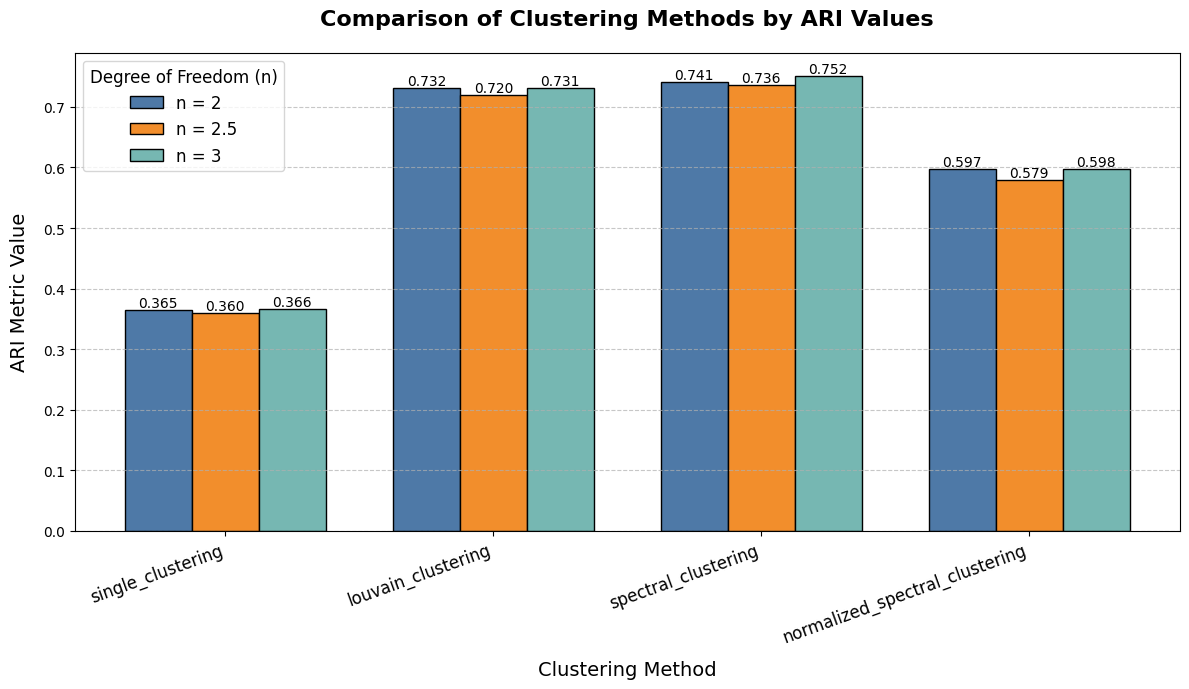

In [140]:
draw_graph("data/diff_student_market")